In [1]:
import yaml
import os 
import gzip
import cloudpickle

import awkward as ak
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep

import hist
from hist import Hist

# from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# from topcoffea.modules.histEFT import HistEFT
# NanoAODSchema.warn_missing_crossrefs = False

# from coffea.analysis_tools import PackedSelection
from topcoffea.modules import utils
import topcoffea.modules.eft_helper as efth

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

import dctr.modules.plotting_tools as plt_tools
import dctr.modules.DNN_tools as DNN_tools

In [2]:
def get_ratio_uncertainty(num_hist, denom_hist):
    '''
    Calculates the propagated uncertainty per bin on the ratio of two historgams

    Parameters
    ----------
        num_hist (scikithep hist): numerator histogram
        denom_hist (scikithep hist): Denominator histogram
    
    Returns:
        list of uncertainties, one entry per histogram bin
    '''

    xvals = num_hist.axes.centers[0]
    yvals_num = num_hist.values()
    yvals_denom = denom_hist.values()
    sigma_num = np.sqrt(num_hist.variances())
    sigma_denom = np.sqrt(denom_hist.variances())

    ratio = np.divide(yvals_num, yvals_denom)

    # calculation for error propagation for ratio = yavls_num/yvals_denom
    # generally, z=x/y; sigma_z = abs(z)sqrt((sigma_x/x)^2+(sigma_y/y)^2)
    sigma_y = np.multiply(np.abs(ratio), np.sqrt(np.add(np.square(np.divide(sigma_num, yvals_num)), np.square(np.divide(sigma_denom, yvals_denom)))))

    return sigma_y

def get_ratio_points(num_hist, denom_hist):
    '''
    Calculates the ratio between two histograms

    Parameters
    ----------
        num_hist (scikithep hist): numerator histogram
        denom_hist (scikithep hist): Denominator histogram

    Returns:
        centers: list of the x-axis point that the ratio corresponds to
        ratio: list of the ratio value (one for each hist bin)
    '''

    num = num_hist.values()
    centers = num_hist.axes.centers[0]
    denom = denom_hist.values()
    ratio = np.divide(num, denom)

    return centers, ratio

In [3]:
# f_smeft = "smeft_1908.pkl.gz"
# f_smeft_reweight = "smeft_rwgt_1808.pkl.gz"
# # f_smeft_reweight_reg = "smeft_rwgt_1408_reg.pkl.gz"
# f_powheg = "powheg_1808.pkl.gz"

f_smeft = "smeft_2008.pkl.gz"
f_smeft_reweight = "smeft_rwgt_2008.pkl.gz"
f_powheg = "powheg_2008.pkl.gz"

smeft_hists = utils.get_hist_from_pkl(f_smeft, allow_empty=False)
smeft_reweight_hists = utils.get_hist_from_pkl(f_smeft_reweight, allow_empty=False)
powheg_hists = utils.get_hist_from_pkl(f_powheg, allow_empty=False)

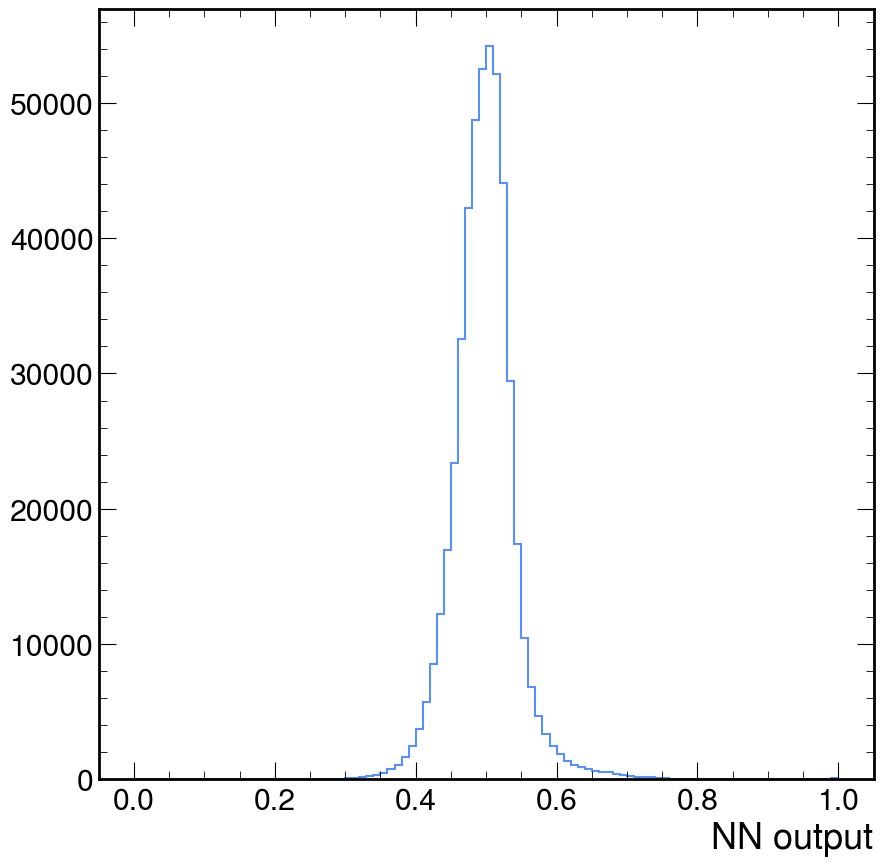

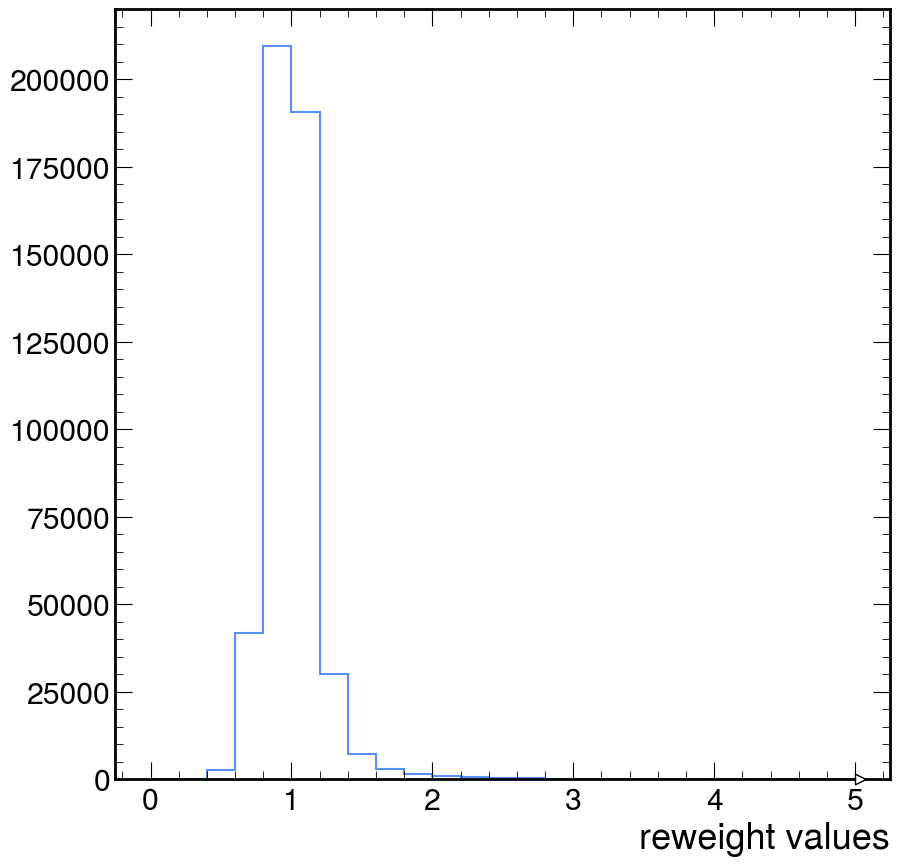

In [6]:
hist_list = ['NNoutput', 'reweights']
for name in hist_list:
    hep.style.use('CMS')
    h = smeft_reweight_hists[name].as_hist({})
    
    fig, ax = plt.subplots()
    hep.style.use('CMS')
    
    h.plot1d(ax=ax, yerr=False)
    
    

In [11]:
f_smeft = "smeft_2008.pkl.gz"
f_smeft_reweight = "smeft_rwgt_2008.pkl.gz"
f_powheg = "powheg_2008.pkl.gz"

smeft_hists = utils.get_hist_from_pkl(f_smeft, allow_empty=False)
smeft_reweight_hists = utils.get_hist_from_pkl(f_smeft_reweight, allow_empty=False)
powheg_hists = utils.get_hist_from_pkl(f_powheg, allow_empty=False)

outdir = "/users/hnelson2/dctr/analysis/reweight_plots"

# name = "NNoutput"

hist_list = powheg_hists.keys()
# hist_list = ['pttt']

for name in hist_list: 
    h_powheg = powheg_hists[name].as_hist({})
    h_smeft = smeft_hists[name].as_hist({})
    h_smeft_rwgt = smeft_reweight_hists[name].as_hist({})

    centers = h_powheg.axes.centers[1]
    edges = h_powheg.axes[1].edges

    h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
    h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())

    hep.style.use('CMS')
    # Initialize figure and axes
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={'height_ratios': (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    # Plot histograms with errors
    norm = False
    # norm = True
    h_powheg.plot1d(ax=ax, density=norm, yerr=False, label='Powheg', color='black')
    h_smeft.plot1d(ax=ax, density=norm, stack=False, yerr=False, linewidth=2, label='SMEFT')
    h_smeft_rwgt.plot1d(ax=ax, density=norm, stack=False, yerr=False, linewidth=2, label='SMEFT rwgt')

    rax.scatter(centers, h_smeft_ratio, label='SMEFT')
    rax.scatter(centers, h_smeft_rwgt_ratio, label='SMEFT rwgt')

    ax.legend(loc='best')
    ax.set_title('Reweighted to SM')
    ax.set_xlabel('')
    rax.set_xlabel(name)
    ax.set_ylabel('Events')

    rax.set_ylim([0.4, 1.6])
    rax.axhline(y=0.5, color='gray', linestyle='--')
    rax.axhline(y=1.0, color='gray', linestyle='--')
    rax.axhline(y=1.5, color='gray', linestyle='--')
    # rax.axhline(y=2.0, color='gray', linestyle='--')
    
    figname = os.path.join(outdir, f"sel_{name}")
    print(f"saving fig to {figname}")
    fig.savefig(f"{figname}.png", bbox_inches='tight')
    plt.close(fig)

saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_sow
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_ptll
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_pttt


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_mtt


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_lep1pt


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_lep2pt
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_top1pt
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_top2pt


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_lep1eta


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_lep2eta
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_top1eta
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_top2eta


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_lep1phi


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_lep2phi


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_top1phi


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_top2phi


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_top1mass


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_top2mass


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_j0pt


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_j0eta


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_j0phi


/tmp/ipykernel_896529/3188947870.py:24: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/3188947870.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/sel_njets


In [12]:
f_smeft_reweight = "smeft_rwgt_nosel.pkl.gz"
f_smeft = "smeft_nosel.pkl.gz"
f_powheg = "powheg_nosel.pkl.gz"


smeft_reweight_hists = utils.get_hist_from_pkl(f_smeft_reweight, allow_empty=False)
smeft_hists = utils.get_hist_from_pkl(f_smeft, allow_empty=False)
powheg_hists = utils.get_hist_from_pkl(f_powheg, allow_empty=False)

outdir = "/users/hnelson2/dctr/analysis/reweight_plots"

# name = "NNoutput"

hist_list = powheg_hists.keys()
# hist_list = ['pttt']

for name in hist_list: 
    h_powheg = powheg_hists[name].as_hist({})
    h_smeft = smeft_hists[name].as_hist({})
    h_smeft_rwgt = smeft_reweight_hists[name].as_hist({})

    centers = h_powheg.axes.centers[1]
    edges = h_powheg.axes[1].edges

    h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
    h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())

    hep.style.use('CMS')
    # Initialize figure and axes
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10,12),
        gridspec_kw={'height_ratios': (3, 1)},
        sharex=True
    )
    fig.subplots_adjust(hspace=.1)

    # Plot histograms with errors
    norm = False
    # norm = True
    h_powheg.plot1d(ax=ax, density=norm, yerr=False, label='Powheg', color='black')
    h_smeft.plot1d(ax=ax, density=norm, stack=False, yerr=False, linewidth=2, label='SMEFT')
    h_smeft_rwgt.plot1d(ax=ax, density=norm, stack=False, yerr=False, linewidth=2, label='SMEFT rwgt')

    rax.scatter(centers, h_smeft_ratio, label='SMEFT')
    rax.scatter(centers, h_smeft_rwgt_ratio, label='SMEFT rwgt')

    ax.legend(loc='best')
    ax.set_title('Reweighted to SM')
    ax.set_xlabel('')
    rax.set_xlabel(name)
    ax.set_ylabel('Events')

    rax.set_ylim([0.4, 1.6])
    rax.axhline(y=0.5, color='gray', linestyle='--')
    rax.axhline(y=1.0, color='gray', linestyle='--')
    rax.axhline(y=1.5, color='gray', linestyle='--')
    # rax.axhline(y=2.0, color='gray', linestyle='--')
    
    figname = os.path.join(outdir, f"nosel_{name}")
    print(f"saving fig to {figname}")
    fig.savefig(f"{figname}.png", bbox_inches='tight')
    plt.close(fig)

saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_sow
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_pttt


/tmp/ipykernel_896529/1298507010.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/1298507010.py:26: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_mtt
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_top1pt
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_top2pt
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_top1eta
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_top2eta


/tmp/ipykernel_896529/1298507010.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/1298507010.py:26: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_top1phi


/tmp/ipykernel_896529/1298507010.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/1298507010.py:26: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_top2phi


/tmp/ipykernel_896529/1298507010.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/1298507010.py:26: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_top1mass


/tmp/ipykernel_896529/1298507010.py:25: RuntimeWarning: invalid value encountered in divide
  h_smeft_ratio = np.divide(h_smeft.values(), h_powheg.values())
/tmp/ipykernel_896529/1298507010.py:26: RuntimeWarning: invalid value encountered in divide
  h_smeft_rwgt_ratio = np.divide(h_smeft_rwgt.values(), h_powheg.values())


saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_top2mass
saving fig to /users/hnelson2/dctr/analysis/reweight_plots/nosel_njets
